---
format:
  html:
    code-fold: false
---


### Using `PETSc` : Sparse solvers


In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

import femsolver
from femsolver.utils import auto_vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors

import jax.numpy as jnp
from jax import Array
import equinox as eqx

from petsc4py import PETSc

from typing import Callable, Optional, Tuple
import sparsejac

import numpy as np

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

### PETSc solvers

The various `PETSc` solvers that we will use in this tutorial are:

- `SNES` : Non-linear solvers.

### SNES

The `SNES` object is used to solve non-linear systems of the form $F(x) = 0$.


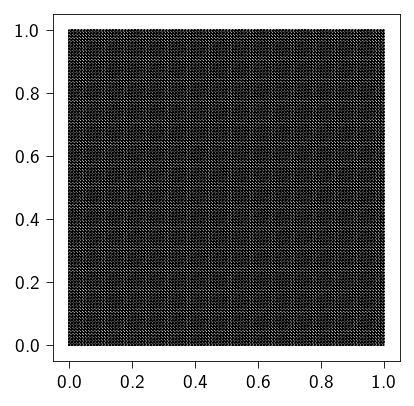

In [52]:
mesh = Mesh.unit_square(100, 100)

n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

plt.style.use(STYLE_PATH)
plt.figure(figsize=(3, 3))
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")
plt.show()

In [53]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


mat = Material(mu=0.5, lmbda=1.0)

In [54]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@auto_vmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)

In [55]:
tri = element.Tri3()
op = Operator(mesh, tri)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

In [56]:
@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    return total_strain_energy(u)

In [57]:
# --- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

In [58]:
u = np.zeros(n_dofs)
u_lower_bounds = np.full(n_dofs, -jnp.inf)
u_upper_bounds = np.full(n_dofs, jnp.inf)

u_lower_bounds[fixed_dofs] = 0.0
u_lower_bounds[2 * right_nodes] = 0.3

u_upper_bounds[fixed_dofs] = 0.0
u_upper_bounds[2 * right_nodes] = 0.3

In [61]:
gradient = jax.jacrev(total_energy)

class JAXMatMult:
    def __init__(self, gradient: Callable):
        self.x_cur = None
        self.gradient = gradient

    def set_x(self, x: Array):
        """Set the current iterate for the Jacobian-vector product."""
        self.x_cur = x

    def mult(self, A, X, F):
        """Set dF = J(x) * dx"""
        dx = X.getArray(readonly=True)
        tangent = jax.jvp(self.gradient, (self.x_cur,), (dx,))[1]
        F[:] = tangent


class ElasticityProblem:
    def __init__(self, func):
        self.gradient = func
        self.ctx = JAXMatMult(func)

    def set_sol(self, sol):
        self.sol_cur = sol

    def function(self, snes, X, F):
        print(X.getArray(readonly=True))
        x = jnp.array(X.getArray(readonly=True))
        f = self.gradient(x)
        F[:] = f

    def jacobian(self, snes, X, J, P):
        self.ctx.set_x(X.getArray(readonly=True))
        return True

In [62]:
problem = ElasticityProblem(gradient)

In [63]:
snes = PETSc.SNES().create(comm=PETSc.COMM_SELF)
f = PETSc.Vec().createSeq(n_dofs)
J = PETSc.Mat().createPython(
    [n_dofs, n_dofs], comm=PETSc.COMM_SELF, context=problem.ctx
)
J.setUp()

snes.setFunction(problem.function, f)
snes.setJacobian(problem.jacobian, J, J)

alpha_lb = f.duplicate()
alpha_ub = f.duplicate()
alpha_lb.setArray(u_lower_bounds.reshape(-1))
alpha_ub.setArray(u_upper_bounds.reshape(-1))

snes.getKSP().setType("cg")
snes.setType("vinewtonrsls")
snes.setVariableBounds(alpha_lb, alpha_ub)
snes.setTolerances(atol=1e-8, rtol=1e-8, max_it=20)
snes.setConvergenceHistory()
snes.setConvergedReason(reason=PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS)
snes.getKSP().setConvergedReason(reason=PETSc.KSP.ConvergedReason.CONVERGED_ATOL)
b, alpha = None, f.duplicate()


alpha.setArray(u.reshape(-1))  # zero inital guess
snes.solve(b, alpha)

u_solution = alpha.getArray().reshape((n_nodes, n_dofs_per_node))
_ = snes.destroy()

[0.  0.  0.  ... 0.  0.3 0. ]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.92394302e-05
  3.00000000e-01 -1.80492810e-05]
[ 0.          0.          0.         ... -0.07732657  0.3
 -0.07884844]
[ 0.          0.          0.         ... -0.0772023   0.3
 -0.07872399]


In [64]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
stress_vm = von_mises_stress(stresses)

In [65]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_displacement_and_stress(u, mesh, stress, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

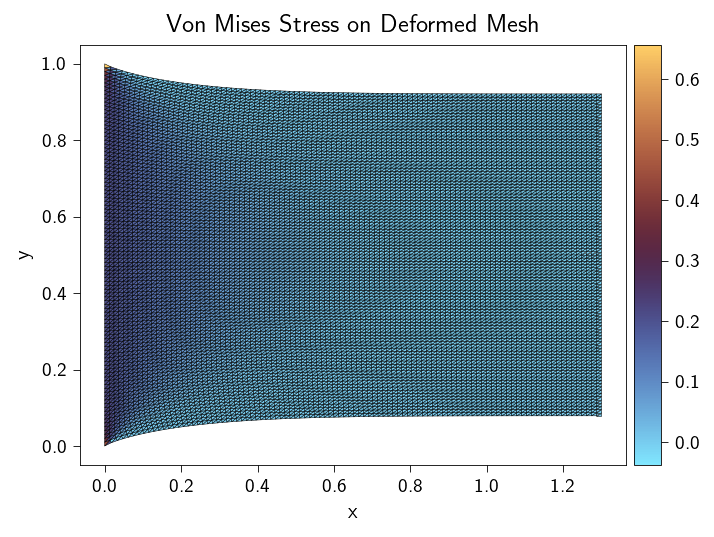

In [72]:
plot_displacement_and_stress(u_solution, mesh, stresses[:, 1, 1].flatten())